In [1]:
import math
import json
import os
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta, time
from research.utils.data_access_utils import RDSAccessUtils
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

In [2]:
queryCache = {}

In [8]:
# pen5 = pd.read_csv('blom_vikane_singleweights.csv')

In [ ]:
# pen5['weight']

In [9]:
# plt.hist(pen5['weight'], bins = 50)

In [5]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

def getPenDF(pen):
    akpd_filter = 0.99

    query = """
       SELECT * FROM prod.biomass_computations
        WHERE prod.biomass_computations.captured_at >= '%s'
        AND prod.biomass_computations.captured_at <= '%s'
        AND prod.biomass_computations.akpd_score > %0.4f
        AND prod.biomass_computations.pen_id = %i;
    """ % (pen['start_date'], pen['end_date'], akpd_filter, pen['pen_id'])

    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
    depths = []
    for idx, row in df.iterrows():
        ann, cm = row.annotation, row.camera_metadata
        wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
        depth = np.median([wkp[1] for wkp in wkps.values()])
        vector = wkps['UPPER_LIP'] - wkps['TAIL_NOTCH']
        depths.append(depth)
    df['depth'] = depths
    
    return df

def getNegativeWeightDF():
    akpd_filter = 0.99

    query = """
       SELECT * FROM prod.biomass_computations
        WHERE prod.biomass_computations.estimated_weight_g < 0
        AND prod.biomass_computations.akpd_score > %0.4f
        AND camera_metadata is not null;
    """ % (akpd_filter, )

    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
    return df

pens = [
    {
        'pen_id': 60,
        'start_date': '2020-08-24 00:00',
        'end_date': '2020-08-26 00:00'
    }
]

df1 = getPenDF(pens[0])
# df2 = getNegativeWeightDF()

(array([ 99.,  19., 212., 496., 195., 256., 338.,  78.,  29., 113.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

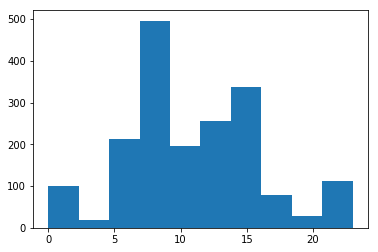

In [6]:
plt.hist(df1.hour)

In [10]:
df1.head()

max(df1.estimated_weight_g)

6782.466769218445

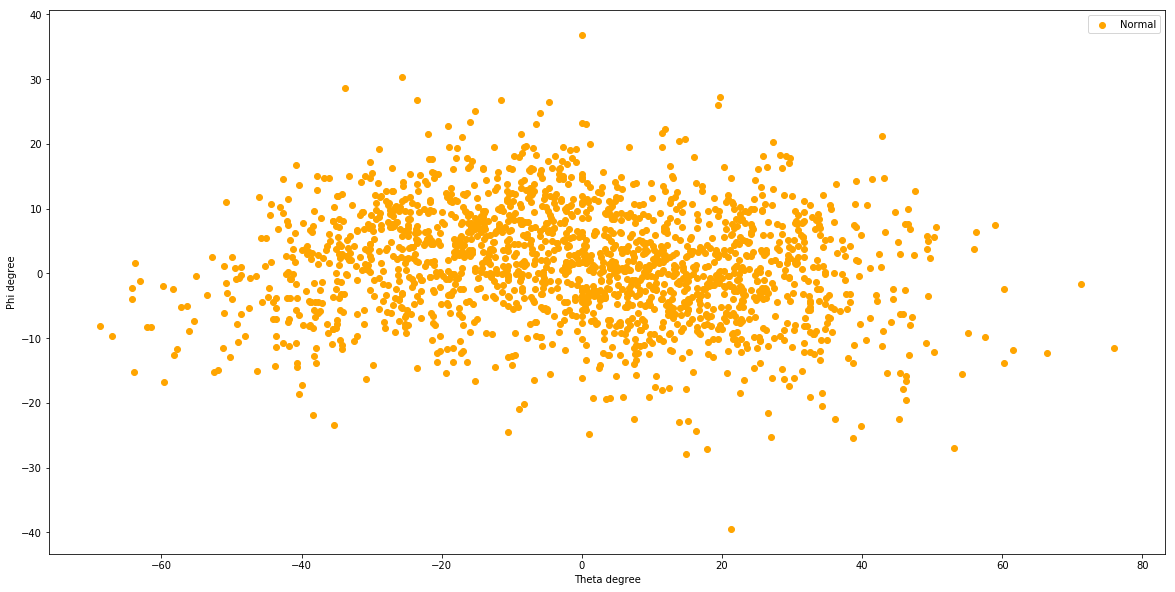

In [11]:
thetas = []
phis = []

for index, row in df1.iterrows():
    ann1, cm1 = row.annotation, row.camera_metadata
    wkps1 = pixel2world(ann1['leftCrop'], ann1['rightCrop'], cm1)

    vector = wkps1['PECTORAL_FIN'] - wkps1['ANAL_FIN']
    x, y, z = vector / np.linalg.norm(vector)
    
    theta = math.atan(y / x) * np.sign(y)
    phi = math.acos(z)
    dtheta = math.degrees(theta)
    dphi = 90 - math.degrees(phi)
    thetas.append(dtheta)
    phis.append(dphi)
    
plt.figure(figsize=(20, 10))
plt.scatter(thetas, phis, color = 'orange', label = 'Normal')
# plt.scatter(thetas2, phis2, color = 'blue', label = 'Negative')
plt.xlabel('Theta degree')
plt.ylabel('Phi degree')
plt.legend()

df1['theta'] = thetas
df1['phi'] = phis


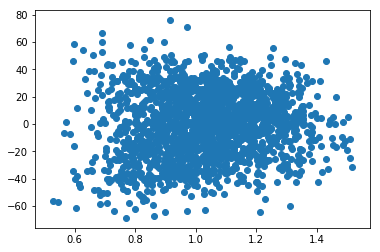

In [14]:
plt.scatter(df1['depth'], df1['theta'])

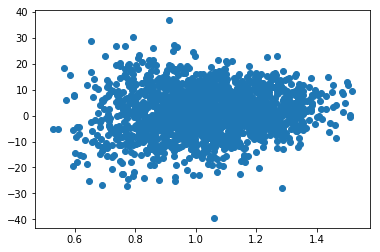

In [15]:
plt.scatter(df1['depth'], df1['phi'])

NameError: name 'pen5' is not defined

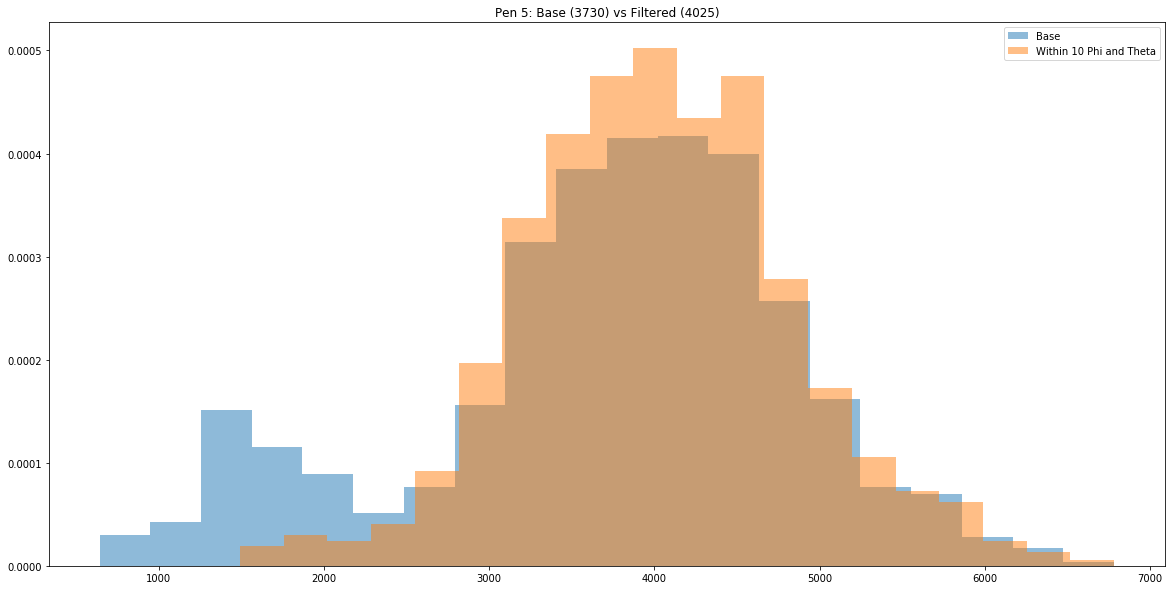

<Figure size 1440x720 with 0 Axes>

In [12]:
plt.figure(figsize=(20, 10))

# mask = np.abs(df1.theta) < 10
# mask2 = (np.abs(df1.theta) < 10) & (np.abs(df1.phi) < 10)
mask2 = (df1.hour >= 5) & (df1.hour <= 15)

a1, s1 = np.mean(df1[mask2].estimated_weight_g), np.mean(df1.estimated_weight_g), 
plt.hist(df1.estimated_weight_g, density = True, alpha = 0.5, label = 'Base', bins = 20)
#plt.hist(df1[mask].estimated_weight_g, density = True, alpha = 0.5, label = 'Within 20', bins = 20)
plt.hist(df1[mask2].estimated_weight_g, density = True, alpha = 0.5, label = 'Within 10 Phi and Theta', bins = 20)
plt.legend()
plt.title('Pen 5: Base (%i) vs Filtered (%i)' % (s1, a1))\

plt.figure(figsize=(20, 10))
s1, a1, b1 = np.mean(pen5['weight'] * 1000 / 0.83), np.mean(df1.estimated_weight_g), np.mean(df1[mask2].estimated_weight_g)
# plt.hist(df1.estimated_weight_g, density = True, alpha = 0.5, label = 'Aquabyte', bins = 20)
plt.hist(pen5.weight * 1000 / 0.83, density = True, alpha = 0.5, label = 'Sampling', bins = 20)
plt.hist(df1[mask2].estimated_weight_g, density = True, alpha = 0.5, label = 'Within 10 Phi and Theta', bins = 20)
plt.legend()
plt.title('Pen 5: Ground Truth (%i) vs Before (%i) vs After (%i)' % (s1, a1, b1))

In [13]:
print(np.mean(pen5.weight * 1000 / 0.83), np.mean(df1[mask2].estimated_weight_g))

y = np.arange(0, 1.5, 0.01)
plt.plot(y, [np.mean(df1[mask2].estimated_weight_g[df1[mask2].depth > x]) for x in y])

np.max([np.mean(df1[mask2].estimated_weight_g[df1[mask2].depth > x]) for x in y])
np.mean(df1[mask2].estimated_weight_g[df1[mask2].depth > np.percentile(df1[mask2].depth, 90)])

NameError: name 'pen5' is not defined

In [ ]:
x = np.arange(0, 100, 1)
plt.plot(x, [np.percentile(df1[mask2].depth, y) for y in x])

In [ ]:
x = np.arange(0, 100, 1)
output = []

for y in x:
    df2 = df1[((df1.hour >= 5) & (df1.hour <= 15))]
    d1 = df2['estimated_weight_g']
    d2 = df2.estimated_weight_g[df2.depth > np.percentile(df2.depth, y)]
    d3 = np.concatenate([d1[d1 < np.mean(d2)], np.mean(d2) + (np.mean(d2) - d1[d1 < np.mean(d2)])])
    d4 = np.concatenate([d1[d1 < np.median(d2)], np.median(d2) + (np.median(d2) - d1[d1 < np.median(d2)])])
    output.append(np.mean(d4))

plt.plot(x, output)

In [ ]:
df2 = df1[((df1.hour >= 5) & (df1.hour <= 15))]
d1 = df2['estimated_weight_g']
d2 = df2.estimated_weight_g[df2.depth > np.percentile(df2.depth, 75)]
d3 = np.concatenate([d1[d1 < np.mean(d2)], np.mean(d2) + (np.mean(d2) - d1[d1 < np.mean(d2)])])
d4 = np.concatenate([d1[d1 < np.median(d2)], np.median(d2) + (np.median(d2) - d1[d1 < np.median(d2)])])
print(np.mean(pen5.weight * 1000 / 0.83), np.mean(d1), np.mean(d2), np.mean(d3))

In [ ]:
buckets = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
x_buckets = np.array(buckets[:-1])

gt_pcts = []
pcts1 = []
pcts2 = []
pcts3 = []

for i in range(len(buckets) - 1):
    mask1 = (d4 > buckets[i]) & (d4 <= buckets[i + 1])
    mask2 = (d2 > buckets[i]) & (d2 <= buckets[i + 1])
    mask3 = (d3 > buckets[i]) & (d3 <= buckets[i + 1])
#     mask_new = (new_bins_adj > buckets[i]) & (new_bins_adj <= buckets[i + 1])
    mask_gt = (pen5.weight * 1000 / 0.83 > buckets[i]) & (pen5.weight * 1000 / 0.83 <= buckets[i + 1])
#     dist = dist1['estimated_weight_g'][mask1]
#     gt = gt_weights[mask2]

#     new_pcts.append(np.sum(new_density_adj[mask_new]))
    pct1 = np.sum(mask1) / len(mask1)
    pcts1.append(pct1)
    pct2 = np.sum(mask2) / len(mask2)
    pcts2.append(pct2)
    pct3 = np.sum(mask3) / len(mask3)
    pcts3.append(pct3)
    gt_pct = np.sum(mask_gt) / len(mask_gt)
    gt_pcts.append(gt_pct)
#     print('%i: %0.3f, %0.3f vs %0.3f' % (buckets[i], np.sum(new_density_adj[mask1]) - gt_pct, np.sum(new_density_adj[mask1]), gt_pct))

plt.figure(figsize=(20, 10))
# plt.bar(x_buckets - 300, new_pcts, color = 'orange', width = 150, label = 'Dedup diff')
plt.bar(x_buckets - 150, pcts1, color = 'red', width = 150, label = 'Original')
plt.bar(x_buckets + 300, pcts2, color = 'blue', width = 150, label = 'Dedup')
plt.bar(x_buckets + 150, pcts3, color = 'purple', width = 150, label = 'Dedup diff')
plt.bar(x_buckets, gt_pcts, color = 'green', width = 150, label = 'Ground truth')

In [ ]:
np.mean(pen5.weight * 1000 / 0.83), np.mean(df1[mask2].estimated_weight_g)
np.max(df1[mask2].depth)

In [ ]:
all_pct, new_pct = [], []

for i in np.arange(0, 100, 1):
    all_pct.append(np.percentile(df1.estimated_weight_g, i))
    new_pct.append(np.percentile(pen5.weight * 1000 / 0.83, i))
    
plt.scatter(all_pct, new_pct)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.xlabel('Aquabyte weights')
plt.ylabel('Sampled weights')
plt.title('All weights vs deduplicated weights')

In [ ]:
# plt.figure(figsize=(20, 10))

# plt.scatter(df1['phi'], df1.estimated_k_factor)

# import statsmodels.api as sm

# X = sm.add_constant(np.abs(df1['phi']))
# y = df1.estimated_k_factor
# model = sm.OLS(y, X)
# results = model.fit()
# print(results.summary())

from scipy.stats import pearsonr
print(pearsonr(df1['phi'], df1['theta'])[0])

In [ ]:
limits = np.arange(10, 50)
weights = []

for limit in limits:
    mask = np.abs(df1.theta) < limit
    weight = np.mean(df1[mask].estimated_weight_g)
    print(limit, weight, np.sum(mask))
    weights.append(weight)
    
plt.figure(figsize=(20, 10))
plt.plot(limits, weights)
plt.xlabel('Theta limit')
plt.ylabel('Average weight')
plt.title('Weight vs Theta Limit')

In [ ]:
limits = np.arange(2, 50)
weights = []

for limit in limits:
    mask = np.abs(df1.phi) < limit
    weight = np.mean(df1[mask].estimated_weight_g)
    print(limit, weight, np.sum(mask))
    weights.append(weight)
    
plt.figure(figsize=(20, 10))
plt.plot(limits, weights)
plt.xlabel('Phi limit')
plt.ylabel('Average weight')
plt.title('Weight vs Phi Limit')

In [ ]:
limits = np.arange(0, 50)
weights = []

for limit in limits:
    mask = (np.abs(df1.theta) < limit) & (np.abs(df1.phi) < limit)
    weight = np.mean(df1[mask].estimated_weight_g)
#     print(limit, weight, np.sum(mask))
    weights.append(weight)
    
plt.figure(figsize=(20, 10))
plt.plot(limits, weights)
plt.axhline(4234)
plt.xlabel('Phi + Theta limit')
plt.ylabel('Average weight')
plt.title('Weight vs Phi + Theta Limit')

In [ ]:
(3917 - 3740)/3740


In [ ]:
low_weight = df1[df1.estimated_weight_g < 1000]
low_weight.ix[0]

In [ ]:
index = 0

from IPython.display import Image
from IPython.core.display import HTML 
Image(url=low_weight.ix[index, 'left_crop_url'])

In [ ]:
Image(url=low_weight.ix[index, 'right_crop_url'])

In [ ]:
row1 = low_weight.ix[0]
ann1, cm1 = row1.annotation, row1.camera_metadata
wkps1 = pixel2world(ann1['leftCrop'], ann1['rightCrop'], cm1)
wkps1

In [ ]:
index = -3

from IPython.display import Image
from IPython.core.display import HTML 
Image(url=df2.ix[index, 'left_crop_url'])

In [ ]:
Image(url=df2.ix[index, 'right_crop_url'])

In [ ]:
plt.figure(figsize=(20, 10))

im = plt.imread('left_frame_crop_1628_2136_3788_3000.jpg')
implot = plt.imshow(im)

for ann in df2.ix[-1].annotation['leftCrop']:
    plt.scatter([ann['xCrop']], [ann['yCrop']])
    plt.text(ann['xCrop'], ann['yCrop'], ann['keypointType'], color = 'white')

plt.show()

In [ ]:
plt.figure(figsize=(20, 10))

im = plt.imread('right_frame_crop_772_2124_3100_3000.jpg')
implot = plt.imshow(im)

for ann in df2.ix[-1].annotation['rightCrop']:
    plt.scatter([ann['xCrop']], [ann['yCrop']])
    plt.text(ann['xCrop'], ann['yCrop'], ann['keypointType'], color = 'white')

plt.show()

In [ ]:
row1 = df2.ix[-1]
ann1, cm1 = row1.annotation, row1.camera_metadata
wkps1 = pixel2world(ann1['leftCrop'], ann1['rightCrop'], cm1)
wkps1

In [ ]:
np.linalg.norm(wkps1['UPPER_LIP'] - wkps1['TAIL_NOTCH'])

In [ ]:
row1 = df2.ix[-3]
ann1, cm1 = row1.annotation, row1.camera_metadata
wkps1 = pixel2world(ann1['leftCrop'], ann1['rightCrop'], cm1)
wkps1

In [ ]:
vector = wkps1['PECTORAL_FIN'] - wkps1['ANAL_FIN']
x, y, z = vector / np.linalg.norm(vector)
print(x, y, z)

In [ ]:
import math 
# https://www.mathworks.com/matlabcentral/answers/108850-what-would-the-angles-be-for-a-3d-vector
# ax = math.atan2(np.sqrt(y ** 2 + z ** 2), x)
# ay = math.atan2(np.sqrt(z ** 2 + x ** 2), y)
# az = math.atan2(np.sqrt(x ** 2 + y ** 2), z)

# ax = math.acos(x)
# ay = math.acos(y)
# az = math.acos(z)

# dx = math.degrees(ax)
# dy = math.degrees(ay)
# dz = math.degrees(az)

# print(ax, ay, az)
# print(dx, dy, dz)

# https://math.stackexchange.com/questions/2247039/angles-of-a-known-3d-vector
theta = math.atan(y / x) * np.sign(y)
phi = math.acos(z)
dtheta = math.degrees(theta)
dphi = 90 - math.degrees(phi)
print(theta, phi)
print(dtheta, dphi)

In [ ]:
# thetas2 = []
# phis2 = []

# for index, row in df2.iterrows():
#     ann1, cm1 = row.annotation, row.camera_metadata
#     wkps1 = pixel2world(ann1['leftCrop'], ann1['rightCrop'], cm1)

#     vector = wkps1['PECTORAL_FIN'] - wkps1['ANAL_FIN']
#     x, y, z = vector / np.linalg.norm(vector)
    
#     theta = math.atan(y / x) * np.sign(y)
#     phi = math.acos(z)
#     dtheta = math.degrees(theta)
#     dphi = 90 - math.degrees(phi)
#     thetas2.append(dtheta)
#     phis2.append(dphi)

In [ ]:
# plt.scatter(thetas, phis)

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# soa = np.array([[0, 0, 0, x, y, z]])

# X, Y, Z, U, V, W = zip(*soa)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.quiver(X, Y, Z, U, V, W)
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
# ax.set_zlim([-1, 1])
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# plt.show()

In [ ]:
# df2.head()